### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

metric = 'aupr'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,UCEC,0.00025,42,0,6882
1,TP53,UCEC,0.00025,42,1,6827
2,TP53,UCEC,0.00025,42,2,6923
3,TP53,UCEC,0.00025,42,3,6898
4,TP53,LUAD,0.0005,1,0,6143


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.661710,0.63834,TP53,OV,signal,42,train,0,all_other_cancers,0.1
1,0.089431,0.84457,TP53,OV,signal,42,test,0,all_other_cancers,0.1
2,0.668130,0.60945,TP53,OV,signal,42,cv,0,all_other_cancers,0.1
3,0.685860,0.62514,TP53,OV,signal,42,train,1,all_other_cancers,0.1
4,0.666670,0.97639,TP53,OV,signal,42,test,1,all_other_cancers,0.1


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,TP53,UCEC,0.00025,42,0,6882,0.99924,0.99898,train,all_other_cancers
1,TP53,UCEC,0.00025,42,0,6882,0.89719,0.87748,test,all_other_cancers
2,TP53,UCEC,0.00025,42,0,6882,0.87192,0.84983,cv,all_other_cancers
3,TP53,UCEC,0.00025,42,1,6827,0.99875,0.99850,train,all_other_cancers
4,TP53,UCEC,0.00025,42,1,6827,0.89358,0.80434,test,all_other_cancers


In [6]:
# look at correlation for each cancer type individually
# positive correlation => more features, better performance
corr_cancer_type_df = []

for gene in coefs_perf_df.gene.unique():
    for cancer_type in coefs_perf_df.holdout_cancer_type.unique():
        corr_df = coefs_perf_df[
            (coefs_perf_df.gene == gene) &
            (coefs_perf_df.holdout_cancer_type == cancer_type) &
            (coefs_perf_df.data_type == 'test')
        ]
        try:
            r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)
        except ValueError:
            # this happens when the model wasn't trained on the cancer type
            # for the given gene, just skip
            continue
        corr_cancer_type_df.append(
            [gene, cancer_type, r, p]
        )
    
corr_cancer_type_df = pd.DataFrame(
    corr_cancer_type_df,
    columns=['gene', 'cancer_type', 'pearson_r', 'pearson_pval']
).sort_values(by='pearson_r', ascending=False)

print(corr_cancer_type_df.shape)
corr_cancer_type_df.head()

(46, 4)


,gene,cancer_type,pearson_r,pearson_pval
25,CDKN2A,GBM,0.715246,9.079060e-14
23,CDKN2A,BLCA,0.690901,1.317469e-12
19,TP53,PAAD,0.678785,4.533751e-12
5,TP53,BLCA,0.629480,3.991674e-10
22,CDKN2A,STAD,0.621126,7.892473e-10


Text(0, 0.5, 'Pearson correlation')

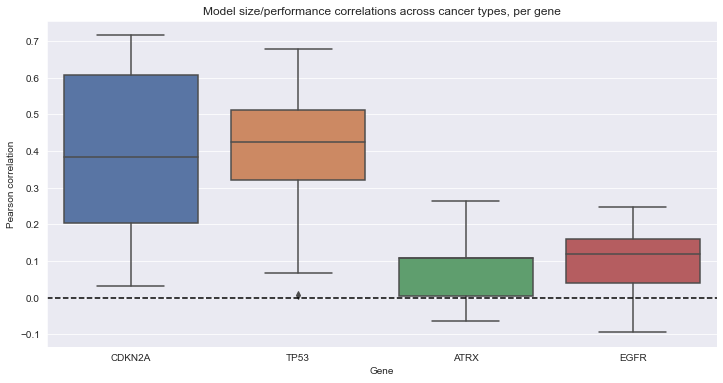

In [7]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (12, 6)})

ax = sns.boxplot(data=corr_cancer_type_df, x='gene', y='pearson_r')
ax.axhline(0.0, linestyle='--', color='black')
plt.title(f'Model size/performance correlations across cancer types, per gene')
plt.xlabel('Gene')
plt.ylabel('Pearson correlation')